In [1]:
!pip install -q tensorflow-gpu

     |████████████████████████████████| 516.2MB 16kB/s 


In [2]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from numpy import array

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
df = pd.read_csv("/content/gdrive/My Drive/colab/dataframe_12g_5m.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
time = df['time'].values

df['time'] = pd.to_datetime(df.time , format = '%d/%m/%Y %H.%M.%S')
df.set_index('time',inplace=True)
points_per_day = 288 

#df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/SafeLab/climate.csv")

df.count()

temperature    3456
humidity       3456
pressure       3456
people         3456
dtype: int64

In [5]:
features_considered = ['pressure', 'temperature', 'humidity']
features = df[features_considered]
features.index = df.index
features.head()

,pressure,temperature,humidity
time,,,
2020-07-07 15:45:00+00:00,1019.5,30.45,40.05
2020-07-07 15:50:00+00:00,1019.5,30.45,40.00
2020-07-07 15:55:00+00:00,1019.5,30.55,39.50
2020-07-07 16:00:00+00:00,1019.5,30.55,39.10
2020-07-07 16:05:00+00:00,1019.5,30.55,39.00


In [6]:
TRAIN_SPLIT = len(df)-2*points_per_day

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  print(range(start_index, end_index))
  print(start_index - end_index)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [8]:
past_history = points_per_day
future_target = 2*12 # 24 points per h so 2 hours prediction
STEP = 3
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

range(288, 2880)
-2592
range(3168, 3432)
-264


In [9]:
print ('Single window of past history : {}'.format(x_train_multi.shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi.shape))
print ('Single window of future history : {}'.format(x_val_multi.shape))
print ('\n Target future temperature to predict : {}'.format(y_val_multi.shape))

Single window of past history : (2592, 96, 3)

 Target temperature to predict : (2592, 24)
Single window of future history : (264, 96, 3)

 Target future temperature to predict : (264, 24)


In [10]:
BATCH_SIZE = 10
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

to_be_predicted = tf.data.Dataset.from_tensor_slices(x_val_multi).batch(1)


In [21]:
def multi_step_plot(history, true_future, prediction):
  
  history_t = (data_std*history) + data_mean
  true_future_t = (data_std[2]*true_future) + data_mean[2]
  prediction_t = (data_std[2]*prediction) + data_mean[2]

  plt.figure(figsize=(20, 10))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history_t[:, 2]), label='History T')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future_t), 'bo',
           label='True Future T')
  if prediction_t.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction_t), 'ro',
             label='Predicted Future T')
  plt.legend(loc='upper left')

  #plt.plot(num_in, np.array(history[:, 1]), label='History')
  #plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
  #         label='True Future')
  #if prediction.any():
  #  plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
  #           label='Predicted Future')
  #plt.legend(loc='upper left')
  #plt.show()

def create_time_steps(length):
  return list(range(-length, 0))

In [12]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [13]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)
  

(10, 24)


In [26]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)



Epoch 1/30
200/200 [==============================] - 14s 70ms/step - loss: 0.0935 - val_loss: 0.6338
Epoch 2/30
200/200 [==============================] - 14s 70ms/step - loss: 0.0920 - val_loss: 0.5578
Epoch 3/30
200/200 [==============================] - 14s 69ms/step - loss: 0.0915 - val_loss: 0.5773
Epoch 4/30
200/200 [==============================] - 14s 70ms/step - loss: 0.0896 - val_loss: 0.5527
Epoch 5/30
200/200 [==============================] - 14s 70ms/step - loss: 0.0861 - val_loss: 0.5471
Epoch 6/30
200/200 [==============================] - 14s 69ms/step - loss: 0.0862 - val_loss: 0.5362
Epoch 7/30
200/200 [==============================] - 14s 70ms/step - loss: 0.0842 - val_loss: 0.5632
Epoch 8/30
200/200 [==============================] - 14s 71ms/step - loss: 0.0825 - val_loss: 0.5614
Epoch 9/30
200/200 [==============================] - 14s 71ms/step - loss: 0.0823 - val_loss: 0.5419
Epoch 10/30
200/200 [==============================] - 15s 75ms/step - loss: 0.080

In [27]:
#multi_step_model.save('/content/gdrive/My Drive/Colab Notebooks/SafeLab/saved_model/24_step_model')
multi_step_model.save('/content/gdrive/My Drive/colab/humidity_model.h5')

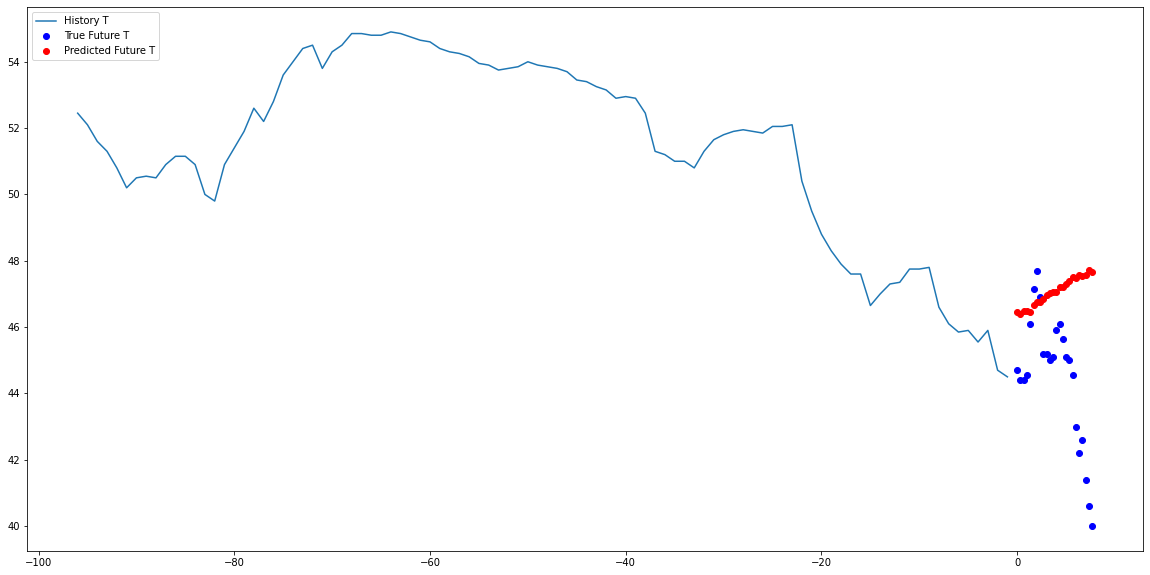

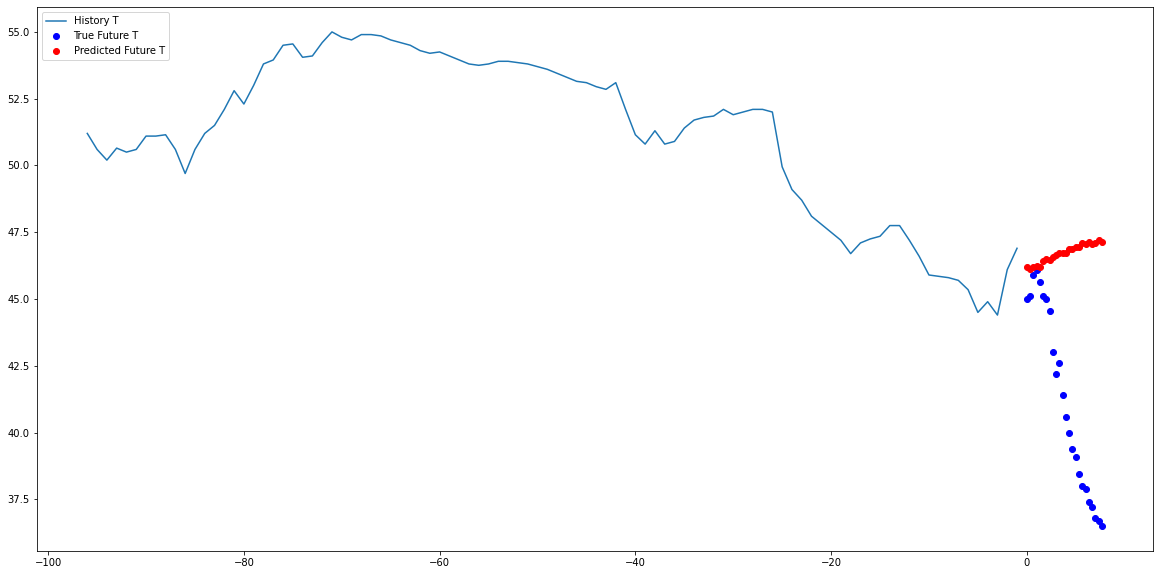

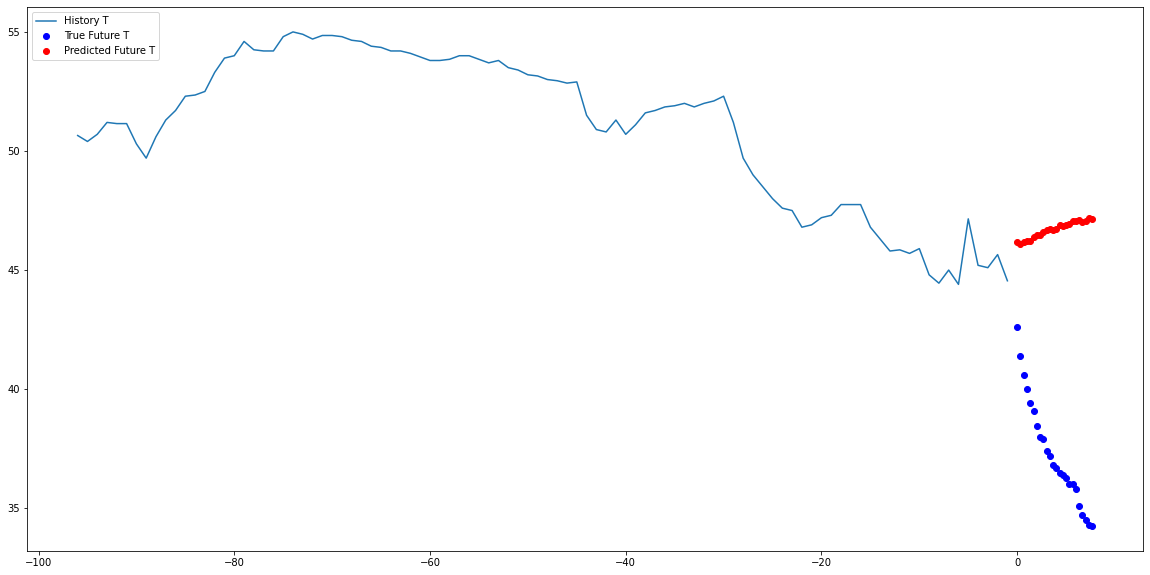

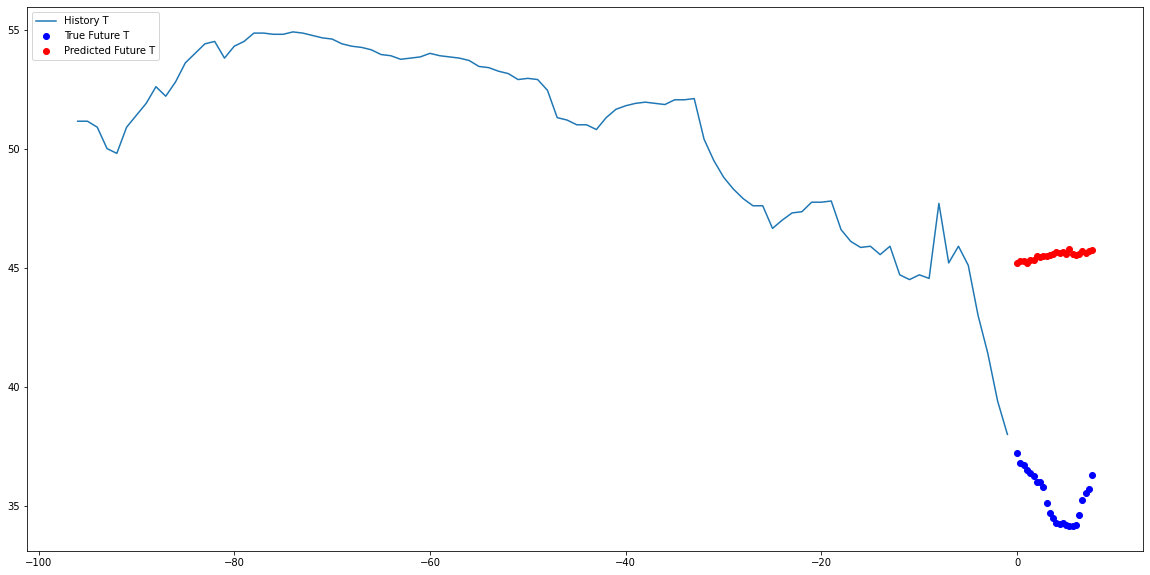

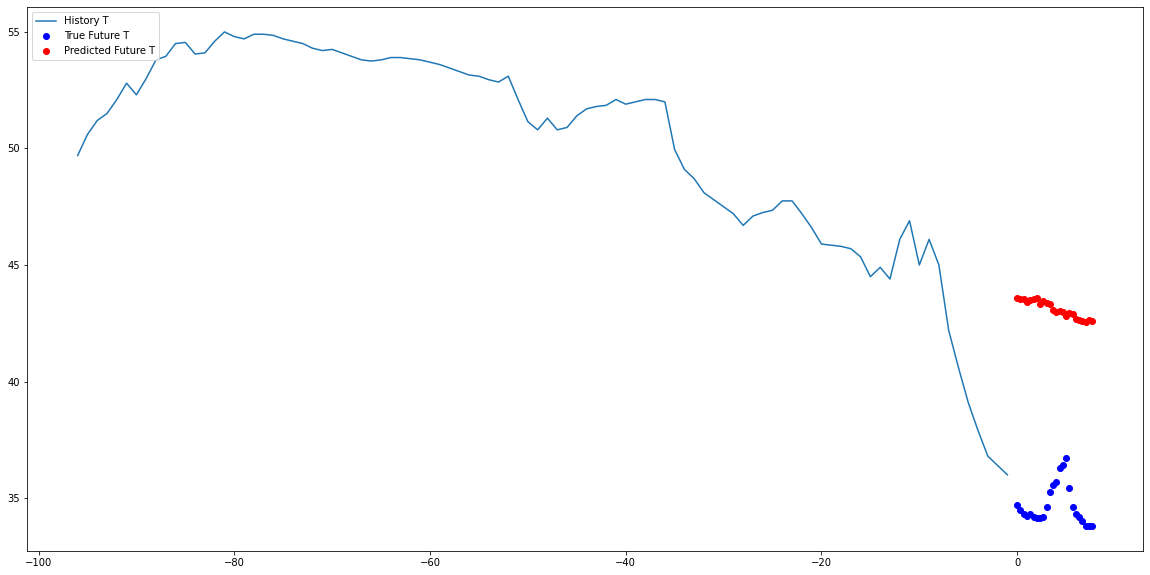

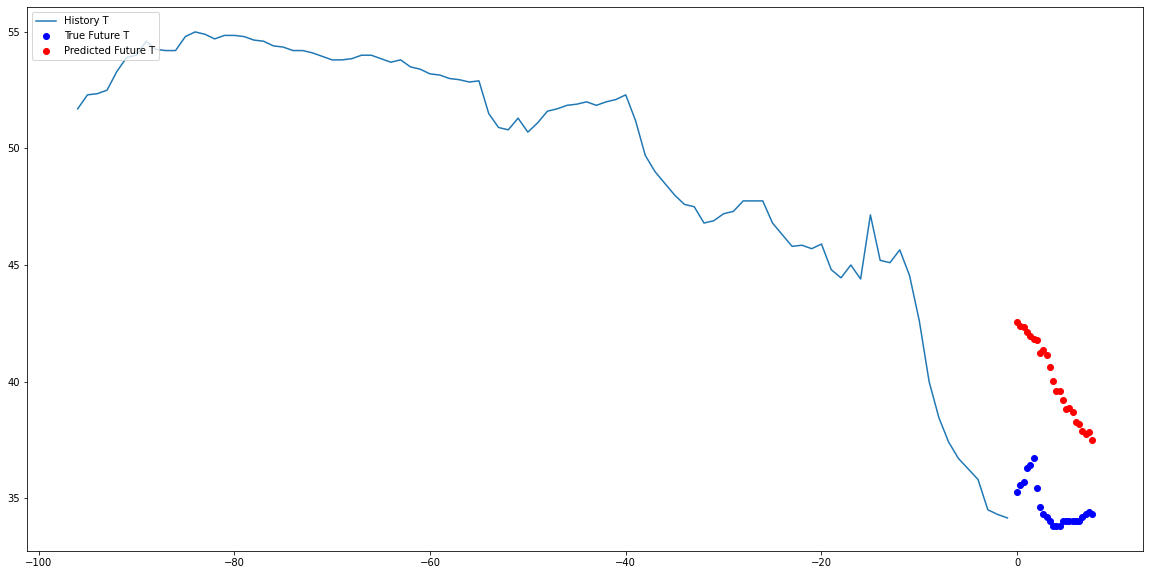

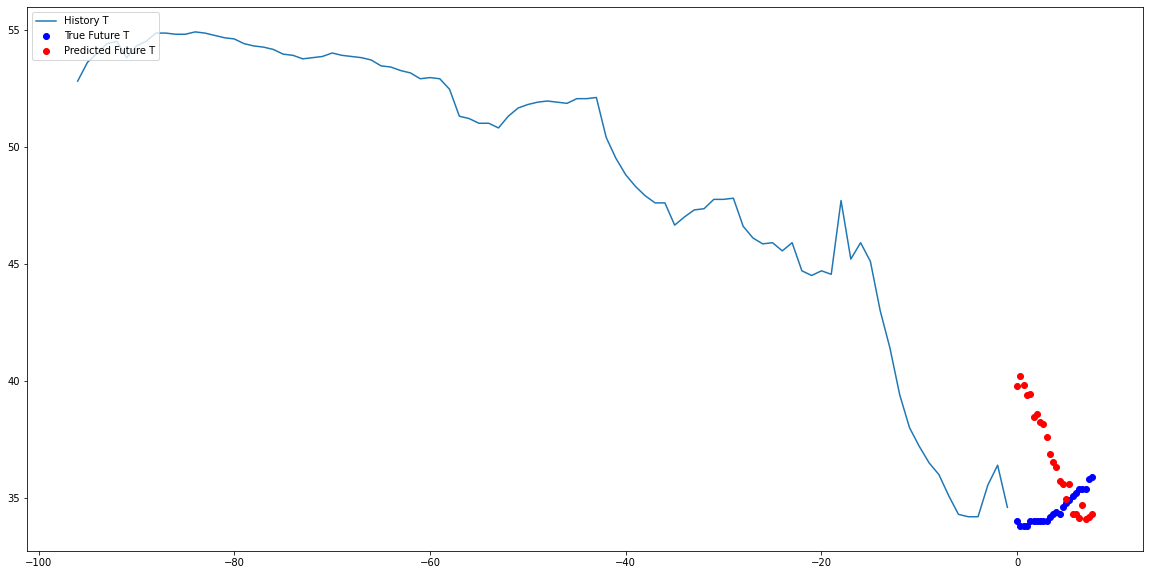

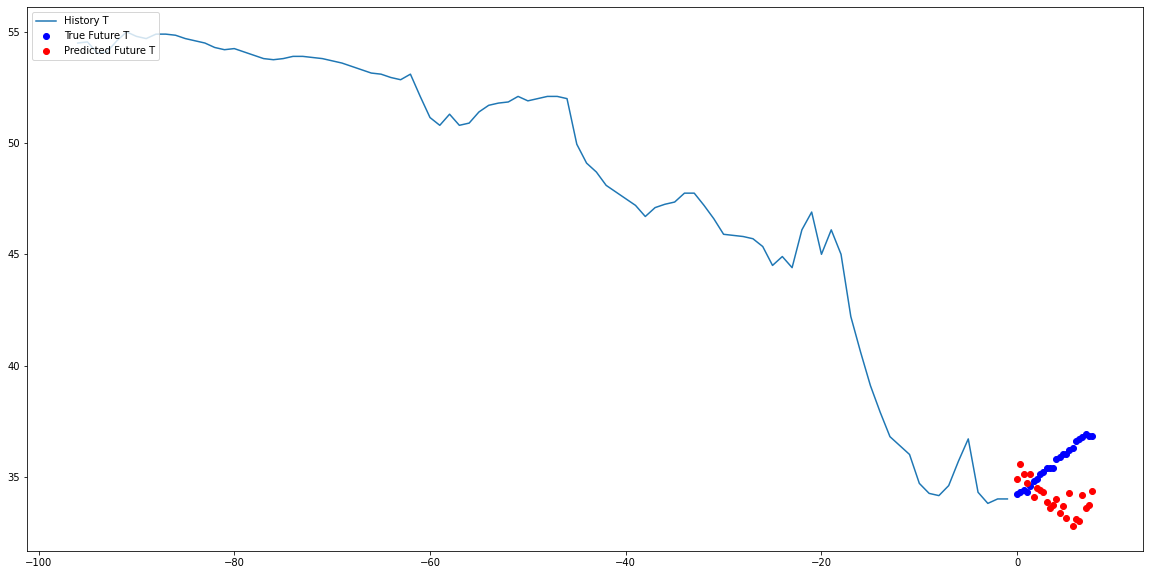

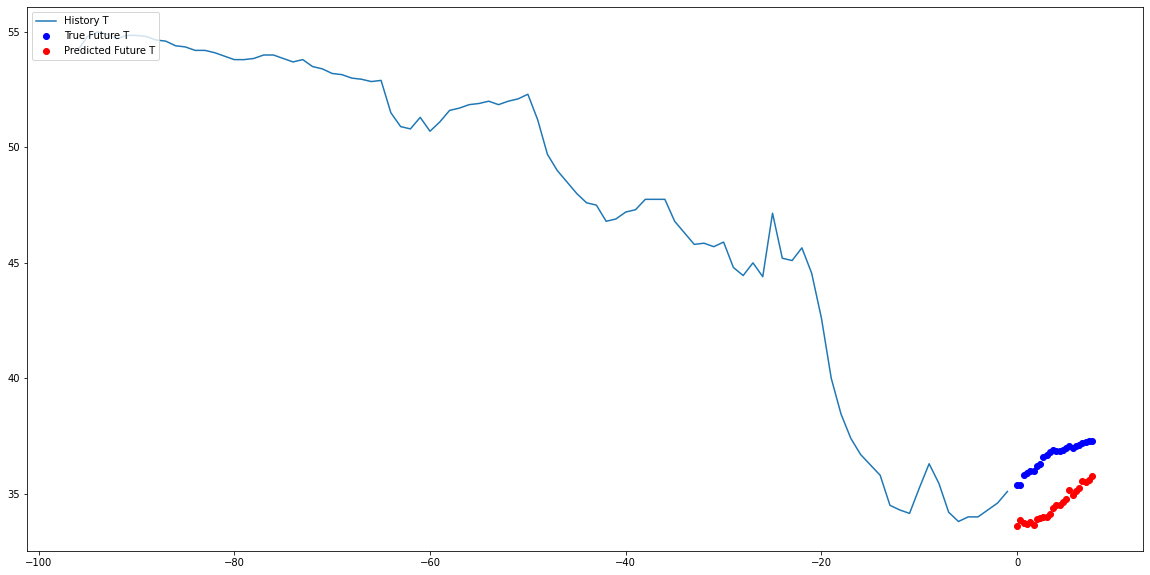

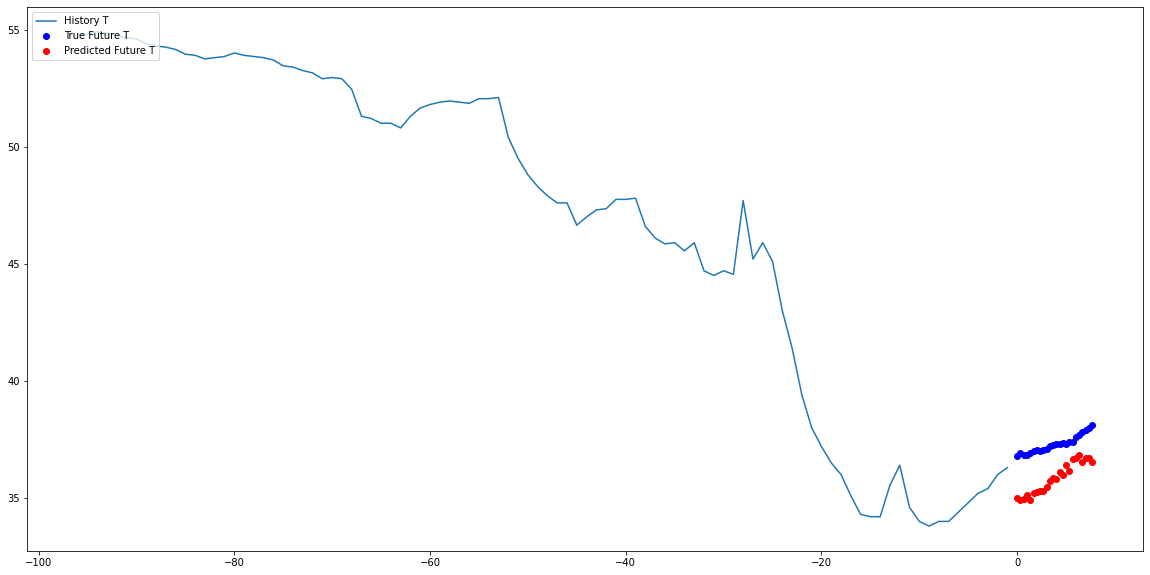

In [28]:
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

#for x, y in val_data_multi.take(2):
# multi_step_plot(x[1], y[1], multi_step_model.predict(x)[1])

#for x, y in to_be_predicted:

  #history = (data_std[1]*x[0]) + data_mean[1]
 # print(x[0].shape)
 # prediction = (data_std[1]*y[0]) + data_mean[1]
  #print(prediction)
  #print(y.shape)
#multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
# prediction = multi_step_model.predict(to_be_predicted)

# prediction_t = (data_std[1]*prediction) + data_mean[1]
# prediction_t

In [29]:
score = multi_step_model.evaluate(x_val_multi, y_val_multi, batch_size=BATCH_SIZE, verbose=0)

In [30]:
score

0.4653082489967346